In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


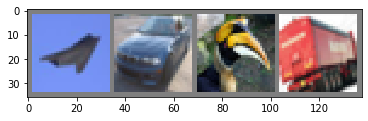

plane car   bird  truck


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join("{:5s}".format(classes[labels[j]]) for j in range(4)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[{}, {:5d}] loss: {:.3f}'.format(
                epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finish Training")

[1,  2000] loss: 2.154
[1,  4000] loss: 1.872
[1,  6000] loss: 1.672
[1,  8000] loss: 1.565
[1, 10000] loss: 1.565
[1, 12000] loss: 1.484
[2,  2000] loss: 1.431
[2,  4000] loss: 1.401
[2,  6000] loss: 1.387
[2,  8000] loss: 1.357
[2, 10000] loss: 1.363
[2, 12000] loss: 1.315
Finish Training


In [17]:
save_path = "./cifar_net.pth"
torch.save(net.state_dict(), save_path)

In [18]:
net = Net()
net.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print("Ground Truth: ", " ".join("{:5s}".format(classes[label]) for label in labels))
print("Predicted: {}".format(" ".join("{:5s}".format(classes[predicted[j]]) for j in range(4))))

Ground Truth:  cat   ship  ship  plane
Predicted: cat   ship  ship  plane


In [53]:
import csv
import os

if not os.path.exists("image"):
    os.mkdir("image")

with open("./output.csv", 'w') as f:
    csv_writer = csv.writer(f)
    
    total = 0
    correct = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for idx, (image, label, pred, out) in enumerate(zip(images, labels, predicted, outputs)):
                filename = saveimage(image, total + idx)
                csv_writer.writerow(
                    [filename, label.item(), pred.item()] + list(out.detach().numpy()))

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
print("Accuracy of the network on the 10000 test images : {:}".format(100 * correct /total))

Accuracy of the network on the 10000 test images : 52.47


In [37]:
def saveimage(image, idx):
    arr = ((image.numpy() + 1.0) * 0.5 * 255).transpose(1, 2, 0)
    img = Image.fromarray(arr.astype(np.uint8))
    save_path = "image/test_{:05d}.png".format(idx)
    img.save(save_path)
    return save_path

#saveimage(images[0], 0)

In [54]:
n_classes = len(classes)
conf_mat = np.zeros((n_classes, n_classes), dtype=np.int)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for label, pred in zip(labels, predicted):
            conf_mat[label, pred] += 1

In [59]:
precision = conf_mat / conf_mat.sum(axis=1)

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [67]:
accuracy = conf_mat.diagonal().sum() / conf_mat.sum()
precision = conf_mat.diagonal() / conf_mat.sum(axis=1)
recall = conf_mat.diagonal() / conf_mat.sum(axis=0)
f1 = 2 * precision * recall / (precision + recall)

0.5247
[0.548 0.736 0.382 0.153 0.474 0.577 0.701 0.595 0.768 0.313]
[0.64775414 0.55172414 0.41075269 0.44347826 0.46884273 0.39493498
 0.53186646 0.67155756 0.53148789 0.73820755]
[0.59371614 0.63067695 0.39585492 0.22750929 0.47140726 0.46891508
 0.60483175 0.63096501 0.62822086 0.43960674]


In [70]:
import csv

with open("results.csv", 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(classes)
    csv_writer.writerow([accuracy])
    csv_writer.writerow(precision)
    csv_writer.writerow(recall)
    csv_writer.writerow(f1)